# Introduction

Biologist have been trying for a long time to distinguishing species and discovering new species. Is it possible for machines to understanding the differences between two species? This project aims to develop a intelligent system which can distinguish different species of Fruit Flies by the audio of its wingbeat.

In this project, I perform features engineering by extract the acoustics features from the original wav recordings. Then I did exploratory data analysis. Finally, I perform Random Forest algorithm (at n_trees = 5, 50, 500) on the new reconstructed data and get accuracy 81.61% on 5, 86.38% on 50, and 87.14% on 500 trees model. In the discussion, I came up with two explanation for phonmenon that the accuracy of "melanogaster" goes down when n_trees increase.

# Procedure

First, I import our training and testing data. Each of them have 17256 rows and 50001 columns. And there is no missing value in these two datasets. The target columns contains three species of Fruit Flies: "melanogaster", "suzukii" and "zaprionus". 

However, there could be a potential imbalance problem when training our model. Considering oversampling method like SMOTE may add more weight when generate trees, and undersampling may lose lots of information, I decided ignore the imbalance problem and I will check F1 score in the final results.

## Import data and check data quality

In [1]:
# Import python library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.io import arff
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import trainning data and testing data
mydata = arff.loadarff('FruitFlies/FruitFlies_TRAIN.arff')
mytestdata = arff.loadarff('FruitFlies/FruitFlies_TEST.arff')

In [3]:
# Check the trainning and testing set
df = pd.DataFrame(mydata[0])
df_test = pd.DataFrame(mytestdata[0])
#df.head()
#df_test.head()
#df.describe()

In [4]:
# Check missing value
df.isna().sum().sum()

0

In [5]:
# Confirm the unique value of target column
df['target'].unique()

array([b'melanogaster', b'suzukii', b'zaprionus'], dtype=object)

b'zaprionus'       9156
b'suzukii'         5071
b'melanogaster'    3032
Name: target, dtype: int64


<AxesSubplot:xlabel='target', ylabel='count'>

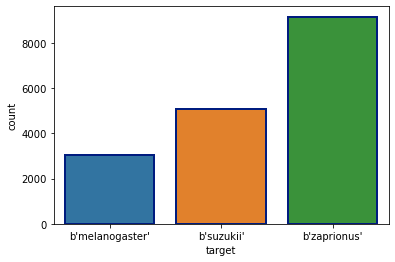

In [6]:
# check the balance stituation
print(df['target'].value_counts())
sns.countplot(x='target',data=df,linewidth=2,edgecolor=sns.color_palette('dark',1))

b'zaprionus'       9156
b'suzukii'         5071
b'melanogaster'    3032
Name: target, dtype: int64


<AxesSubplot:xlabel='target', ylabel='count'>

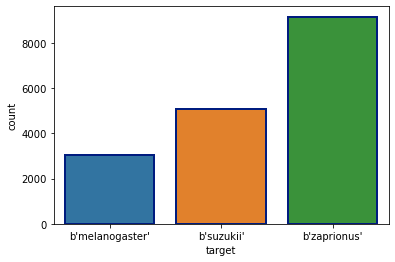

In [7]:
print(df_test['target'].value_counts())
sns.countplot(x='target',data=df_test,linewidth=2,edgecolor=sns.color_palette('dark',1))

This data contains wav recording of Fruit Flies wingbeats, so I want to perform acoustic analysis on this data. And the acoustic features extracted from data can be used as model inputs to predict the Flies species.

Python package `Librosa` helps me to perform feature engineering on this audio data.

## Features Engineering

In [8]:
import librosa
import librosa.display
import IPython.display as ipd

Here you can listen the example recordings by indexing.

In [9]:
# You can even listen this audio file
x = np.asarray(df.iloc[2,:5000])
print(x.shape)
ipd.Audio(x,rate = 8000)
#librosa.display.waveplot(x,sr = 8000)

(5000,)


Visualize the waveplot of a recording.

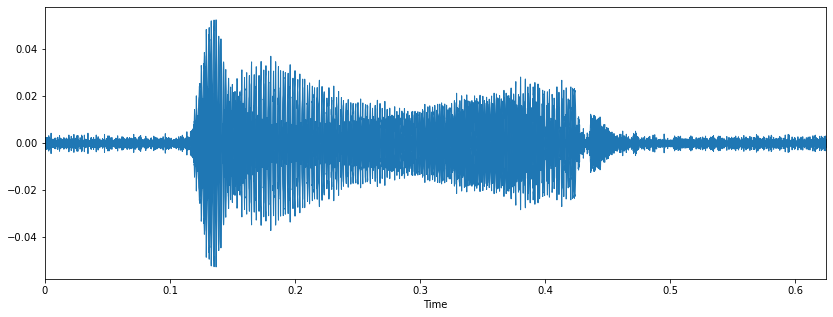

In [10]:
# Make a waveplot
def f(x):
    return np.float(x)
f2=np.vectorize(f)
plt.figure(figsize=(14,5))
librosa.display.waveplot(f2(x),sr=8000)

Here you can visualize the spectrogram of a recording.

Text(0.5, 1.0, 'Spectrogram')

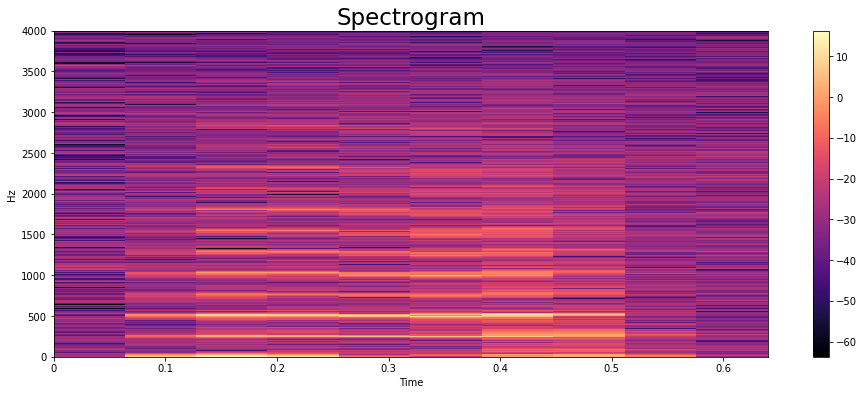

In [11]:
# Make a Spectrogram
x = f2(x)
# Fourier Transformation
X = librosa.stft(x)
# Amp to db
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(16,6))
librosa.display.specshow(Xdb,sr=8000,x_axis='time',y_axis='hz')
plt.colorbar()
plt.title('Spectrogram',fontsize=23)

Here you can see the Mel Spectrogram

Text(0.5, 1.0, 'Mel Spectrogram')

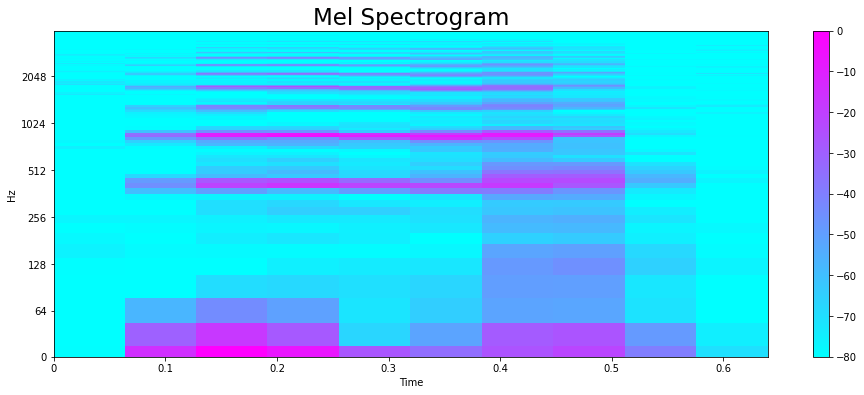

In [12]:
# Make a MEL Spectrogram
y,_=librosa.effects.trim(x)
S = librosa.feature.melspectrogram(y,sr=8000)
S_DB=librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(16,6))
librosa.display.specshow(data=S_DB,sr=8000,x_axis='time',y_axis='log',cmap='cool')
plt.colorbar()
plt.title('Mel Spectrogram',fontsize=23)

### Zero crossing rate

It is a acoustic stats widely used in both speech recognition and music information retrieval, being a key feature to classify percussive sounds.(en_Wikipedia)

In [13]:
# zero crossing rate
zero_crossings = librosa.zero_crossings(y, pad=False)
print(sum(zero_crossings))

1282


### Harmonics and Perceptrual

Harmonics represents the sound color.

Perceptrual understanding shock wave represents the sound rhythm and emotion.
(Andrada Olteanu, 2021)

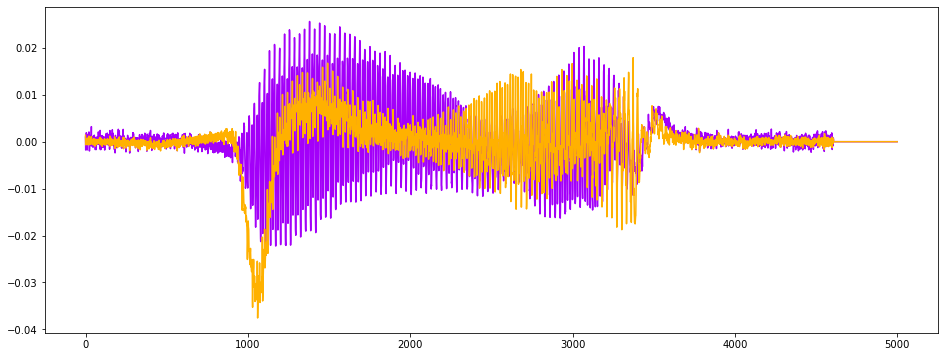

In [14]:
# harmonics and perceptrual
y_harm,y_perc = librosa.effects.hpss(y)
plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

### Tempo Beats Per Minute

The speed of mysic should be played.

In [15]:
# Tempo BMP(beats per minute)
tempo,_=librosa.beat.beat_track(y=y,sr=8000)
tempo

312.5

### Spectral Centroid

Indicates where the "centre of mass". A kind of weighted mean of frequencies in a sounds.

In [16]:
# spectral centroid
spectral_centroids = librosa.feature.spectral_centroid(y,sr=8000)[0]
# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

Centroids: [1850.70130723 1082.19947885  869.45160572  976.42782497 1157.34215028
 1176.78927043 1023.86040854  993.14384834 1462.00936901 1815.8888858 ] 

Shape of Spectral Centroids: (10,) 



### Spectral Rolloff

A measure of the shape of the signal.

In [17]:
# spectral rolloff
spectral_rolloff = librosa.feature.spectral_rolloff(y,sr=8000)[0]
spectral_rolloff

array([3140.625  , 2453.125  , 1867.1875 , 2066.40625, 2300.78125,
       2246.09375, 2007.8125 , 2144.53125, 2917.96875, 3054.6875 ])

### Mel-Frequency Cepstral Coefficients

Describe the overall shape of spectral envelope.

In [18]:
#Mel-Frequency Cepstral Coefficients
mfccs = librosa.feature.mfcc(y,sr=8000)
print('mfccs shape:',mfccs.shape)

mfccs shape: (20, 10)


In [19]:
# Perform Feature Scaling
import sklearn
#mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(axis = 1), '\n')
print('Var:', mfccs.var(axis = 1))

Mean: [-3.34764659e+02  3.67435050e+01 -9.64966340e+00  1.53515111e+01
 -3.79913255e+00  3.14401855e+00 -6.22580989e+00 -2.74350329e-01
 -2.25393136e-01  8.85361595e+00  4.16419611e+00  4.16705921e+00
 -5.64070215e-01  2.51944547e+00 -4.94439084e-01 -2.17471870e+00
  7.03635050e-01  1.09509619e+01  2.58241188e+01  2.37867092e+01] 

Var: [1843.51881735  426.44633907   76.83224964   16.20783876   18.16636713
   12.42683566   22.08299865    9.91045835   17.10038678   35.9689925
   20.47617256    5.36936973    7.66561508   12.4414279    10.86098797
   18.52194708   28.26909477   53.5112926   273.88650049  258.18513436]


Mean: -1.1102230246251566e-17 

Var: 1.0


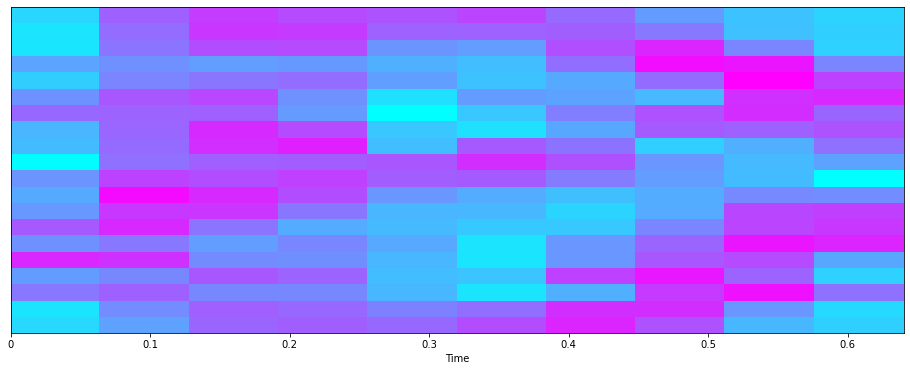

In [20]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=8000, x_axis='time', cmap = 'cool');

### Chroma Frequencies

Chromogram shape: (12, 10)


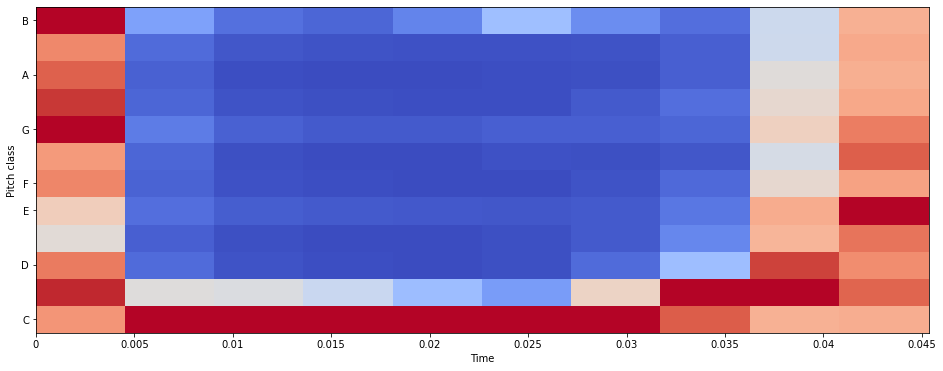

In [21]:
# Chromogram
chromagram = librosa.feature.chroma_stft(y, sr=8000)
print('Chromogram shape:', chromagram.shape)
plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=100, cmap='coolwarm');

## Feature Engineering

Here I write a function to batch process extracting the acoustic features from the training and testing set and reconstructe a dataframe based on them. The new dataframe should have 55 features.

In [22]:
def makeFeatures(df):
    # Make a default numpy array
    tempNp = np.ones((1,55))
    for i in range(len(df)):
        x = np.asarray(df.iloc[i,:5000])
        x = f2(x)
        # Eliminate silence start and end
        y, _ = librosa.effects.trim(x)
        #zero_crossings_rates
        zero_crossings = librosa.zero_crossings(y, pad=False)
        zero_crossings_mean = zero_crossings.mean()
        zero_crossings_var = zero_crossings.var()
        #Harmonics and perceptrual
        y_harm,y_perc = librosa.effects.hpss(y)
        harm_mean = y_harm.mean()
        harm_var = y_harm.var()
        perc_mean = y_perc.mean()
        perc_var = y_perc.var()
        #rms
        rms = librosa.feature.rms(y)
        rms_mean = rms.mean()
        rms_var = rms.var()
        #tempo
        tempo,_=librosa.beat.beat_track(y,sr=8000)
        #Spectral_centroids
        spectral_centroids = librosa.feature.spectral_centroid(y,sr=8000)[0]
        spectral_centroids_mean = spectral_centroids.mean()
        spectral_centroids_var = spectral_centroids.var()
        #Spectral_rolloff
        spectral_rolloff = librosa.feature.spectral_rolloff(y,sr=8000)[0]
        spectral_rolloff_mean = spectral_rolloff.mean()
        spectral_rolloff_var = spectral_rolloff.var()
        #MFCCs
        mfccs = librosa.feature.mfcc(y,sr=8000)
        mfccs_mean = mfccs.mean(axis = 1)
        mfccs_var = mfccs.var(axis = 1)
        #chroma
        chroma = librosa.feature.chroma_stft(y, sr=8000)
        chroma_stft_mean = chroma.mean()
        chroma_stft_var = chroma.var()
        #Make a np array
        temp = np.array([zero_crossings_mean,zero_crossings_var,\
                         harm_mean,harm_var,perc_mean,perc_var,\
                        rms_mean,rms_var,tempo,\
                        spectral_centroids_mean,spectral_centroids_var,\
                        spectral_rolloff_mean,spectral_rolloff_var,\
                        chroma_stft_mean,chroma_stft_var])
        temp = np.append(temp,mfccs_mean).flatten()
        temp = np.append(temp,mfccs_var).flatten().reshape(1,-1)
        tempNp = np.vstack((tempNp,temp)).reshape(-1,55)
        #To track the processing 
        #print('tempNp shape = ', tempNp.shape)
    # Make a dataframe and delete the first row which is all ones.
    newData = pd.DataFrame(tempNp[1:,:],columns = ['zero_crossings_mean','zero_crossings_var',\
                                                   'harm_mean','harm_var','perc_mean','perc_var',\
                                                   'rms_mean','rms_var',\
                                                   'tempo','spectral_centroids_mean',\
                                                   'spectral_centroids_var','spectral_rolloff_mean',\
                                                   'spectral_rolloff_var','chroma_stft_mean',\
                                                   'chroma_stft_var','mfcc1_mean','mfcc2_mean',\
                                                   'mfcc3_mean','mfcc4_mean','mfcc5_mean',\
                                                   'mfcc6_mean','mfcc7_mean','mfcc8_mean',\
                                                   'mfcc9_mean','mfcc10_mean','mfcc11_mean',\
                                                   'mfcc12_mean','mfcc13_mean','mfcc14_mean',\
                                                   'mfcc15_mean','mfcc16_mean','mfcc17_mean',\
                                                   'mfcc18_mean','mfcc19_mean','mfcc20_mean',\
                                                   'mfcc1_var','mfcc2_var',\
                                                   'mfcc3_var','mfcc4_var','mfcc5_var',\
                                                   'mfcc6_var','mfcc7_var','mfcc8_var',\
                                                   'mfcc9_var','mfcc10_var','mfcc11_var',\
                                                   'mfcc12_var','mfcc13_var','mfcc14_var',\
                                                   'mfcc15_var','mfcc16_var','mfcc17_var',\
                                                   'mfcc18_var','mfcc19_var','mfcc20_var'])
    return newData

In [23]:
# Make the trainning and testing dataframe
X_train = makeFeatures(df)
X_test = makeFeatures(df_test)

In [24]:
# Check X_train and X_test
X_train.head()
#X_test.head()

,zero_crossings_mean,zero_crossings_var,harm_mean,harm_var,perc_mean,perc_var,rms_mean,rms_var,tempo,spectral_centroids_mean,...,mfcc11_var,mfcc12_var,mfcc13_var,mfcc14_var,mfcc15_var,mfcc16_var,mfcc17_var,mfcc18_var,mfcc19_var,mfcc20_var
0,0.2084,0.164969,0.000040,0.000002,0.000007,0.000007,0.003658,0.000001,117.1875,1322.890186,...,9.480763,17.692533,16.190684,3.233364,3.443693,3.317442,47.942600,56.874558,8.588669,12.736528
1,0.1794,0.147216,0.001216,0.000561,-0.000530,0.000115,0.027363,0.000131,312.5000,1003.570426,...,36.615616,43.875636,3.686355,18.684012,13.860814,21.757287,19.216183,17.484468,31.864564,35.199646
2,0.2564,0.190659,0.000330,0.000047,-0.000191,0.000036,0.009774,0.000016,312.5000,1240.781415,...,20.476173,5.369370,7.665615,12.441428,10.860988,18.521947,28.269095,53.511293,273.886500,258.185134
3,0.2834,0.203084,0.000191,0.000001,-0.000073,0.000017,0.004061,0.000007,117.1875,1437.417525,...,8.099444,15.336312,4.879668,17.787401,5.166459,11.712410,28.625189,29.577809,20.527605,42.099274
4,0.2452,0.185077,-0.000562,0.000004,0.000329,0.000026,0.005267,0.000008,117.1875,1366.247755,...,1.916161,6.662989,10.583234,5.609363,10.980403,8.057794,2.781916,12.760086,128.988061,139.023021


In [25]:
print('The shape of X_train: ',X_train.shape)
print('The shape of X_test: ',X_test.shape)

The shape of X_train:  (17259, 55)
The shape of X_test:  (17259, 55)


I save the dataframe to csv for future use, therefore I don't need to do features engineering again.

In [26]:
# Save the data file after features engineering
train_file = X_train.assign(target = df['target'])
test_file = X_test.assign(target = df_test['target'])
#train_file.head()
train_file.to_csv('FruitFlies/train.csv')
test_file.to_csv('FruitFlies/test.csv')

In [28]:
y_train = df['target'].map({b'melanogaster': 0,b'suzukii': 1,b'zaprionus':2})
y_test = df_test['target'].map({b'melanogaster': 0,b'suzukii': 1,b'zaprionus':2})

## EDA

Perform a PCA on this dataset.

In [29]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

cols = X_train.columns
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=2)
pca_fitted = pca.fit_transform(X_scaled)
pcaDf = pd.DataFrame(data = pca_fitted, columns = ['V1','V2'])

final_pca = pd.concat([pcaDf,y_train], axis = 1)

print(pca.explained_variance_ratio_)

[0.30854717 0.15049194]


Text(0, 0.5, 'Principal Component 2')

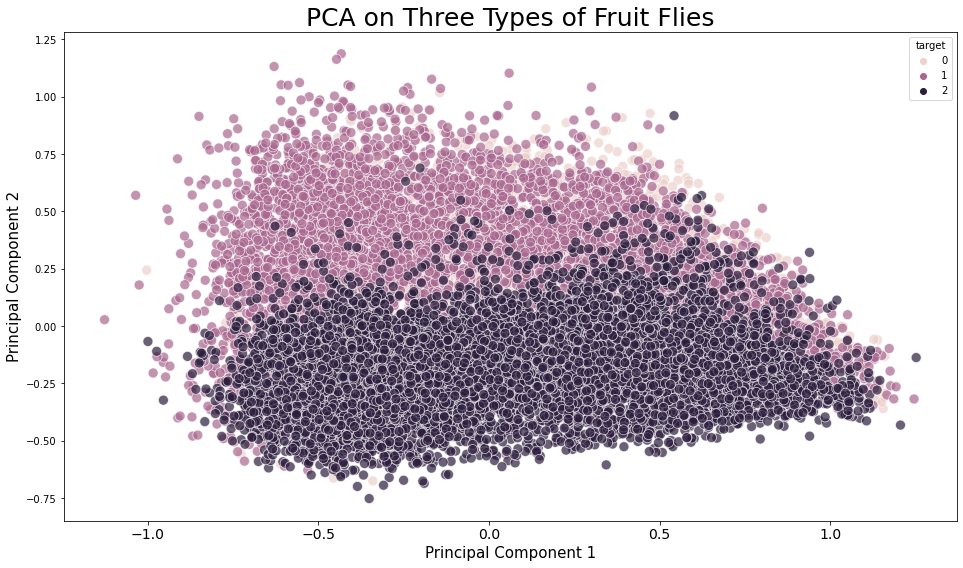

In [30]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "V1", y = "V2", data = final_pca, hue = "target", alpha = 0.7,
               s = 100);

plt.title('PCA on Three Types of Fruit Flies', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)

Parts of boxplots about species versus different acoustic features.

<AxesSubplot:xlabel='target', ylabel='mfcc19_mean'>

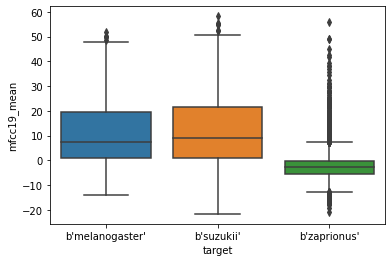

In [31]:
sns.boxplot(x = train_file['target'], y = train_file['mfcc19_mean'])

<AxesSubplot:xlabel='target', ylabel='chroma_stft_mean'>

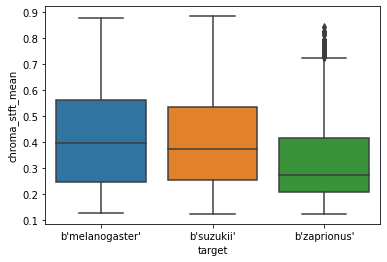

In [32]:
sns.boxplot(x = train_file['target'], y = train_file['chroma_stft_mean'])

## Modeling

I converted the target column to a numeric type to facilitate the input of the model. Then I compared the predict accuracy of the three random forest models on 5 trees, 50 trees and 500 trees. Finally, I also perform Random Forest algorithm on the raw data with n_trees = 500.

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve,confusion_matrix,ConfusionMatrixDisplay

In [34]:
df['target'].unique()

array([b'melanogaster', b'suzukii', b'zaprionus'], dtype=object)

Random Forest(n_estimators = 5) and the confusion matrix.

In [36]:
target_names = ['melanogaster','suzukii','zaprionus']
RFmodel_5trs = RandomForestClassifier(n_estimators=5,random_state = 2021)
RFmodel_5trs.fit(X_train,y_train)
ypred_5 = RFmodel_5trs.predict(X_test)
print(classification_report(y_test,ypred_5,target_names = target_names))
acc_5 = round(sum(y_test == ypred_5)*100/len(y_test),2)
print('Accuracy for 5 trees model equals to ', str(acc_5) + "%")

              precision    recall  f1-score   support

melanogaster       0.60      0.58      0.59      3032
     suzukii       0.75      0.75      0.75      5071
   zaprionus       0.93      0.93      0.93      9156

    accuracy                           0.82     17259
   macro avg       0.76      0.76      0.76     17259
weighted avg       0.82      0.82      0.82     17259

Accuracy for 5 trees model equals to  81.67%


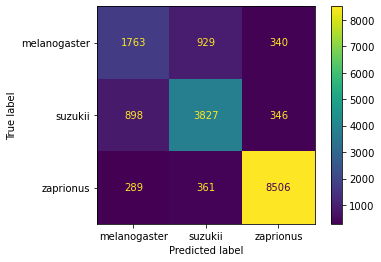

In [37]:
cm_5 = confusion_matrix(y_test,ypred_5)
disp_5 = ConfusionMatrixDisplay(cm_5,display_labels=target_names)
disp_5.plot()

Random Forest(n_estimators = 50) and the confusion matrix.

In [38]:
RFmodel_50trs = RandomForestClassifier(n_estimators=50,random_state = 2021)
RFmodel_50trs.fit(X_train,y_train)
ypred_50 = RFmodel_50trs.predict(X_test)
print(classification_report(y_test,ypred_50,target_names = target_names))
acc_50 = round(sum(y_test == ypred_50)*100/len(y_test),2)
print('Accuracy for 50 trees model equals to ', str(acc_50) + "%")

              precision    recall  f1-score   support

melanogaster       0.78      0.58      0.67      3032
     suzukii       0.80      0.84      0.82      5071
   zaprionus       0.91      0.97      0.94      9156

    accuracy                           0.86     17259
   macro avg       0.83      0.80      0.81     17259
weighted avg       0.86      0.86      0.86     17259

Accuracy for 50 trees model equals to  86.38%


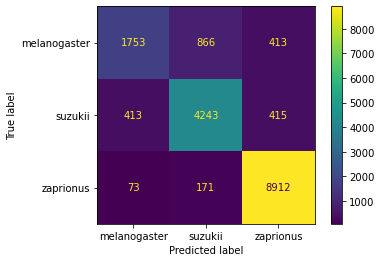

In [39]:
cm_50 = confusion_matrix(y_test,ypred_50)
disp_50 = ConfusionMatrixDisplay(cm_50,display_labels=target_names)
disp_50.plot()

Random Forest(n_estimators = 500) and the confusion matrix.

In [40]:
RFmodel_500trs = RandomForestClassifier(n_estimators=500,random_state = 2021)
RFmodel_500trs.fit(X_train,y_train)
ypred_500 = RFmodel_500trs.predict(X_test)
print(classification_report(y_test,ypred_500,target_names = target_names))
acc_500 = round(sum(y_test == ypred_500)*100/len(y_test),2)
print('Accuracy for 500 trees model equals to ', str(acc_500) + "%")

              precision    recall  f1-score   support

melanogaster       0.82      0.58      0.68      3032
     suzukii       0.81      0.85      0.83      5071
   zaprionus       0.91      0.98      0.94      9156

    accuracy                           0.87     17259
   macro avg       0.85      0.80      0.82     17259
weighted avg       0.87      0.87      0.87     17259

Accuracy for 500 trees model equals to  87.1%


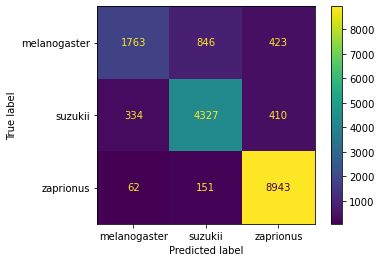

In [41]:
cm_500 = confusion_matrix(y_test,ypred_500)
disp_500 = ConfusionMatrixDisplay(cm_500,display_labels=target_names)
disp_500.plot()

Random Forest(n_estimators = 1000) and the confusion matrix.

In [42]:
RFmodel_1000trs = RandomForestClassifier(n_estimators=1000,random_state = 2021)
RFmodel_1000trs.fit(X_train,y_train)
ypred_1000 = RFmodel_1000trs.predict(X_test)
print(classification_report(y_test,ypred_1000,target_names = target_names))
acc_1000 = round(sum(y_test == ypred_1000)*100/len(y_test),2)
print('Accuracy for 1000 trees model equals to ', str(acc_1000) + "%")

              precision    recall  f1-score   support

melanogaster       0.82      0.58      0.68      3032
     suzukii       0.81      0.85      0.83      5071
   zaprionus       0.91      0.98      0.94      9156

    accuracy                           0.87     17259
   macro avg       0.85      0.80      0.82     17259
weighted avg       0.87      0.87      0.87     17259

Accuracy for 1000 trees model equals to  87.15%


### Features Importance

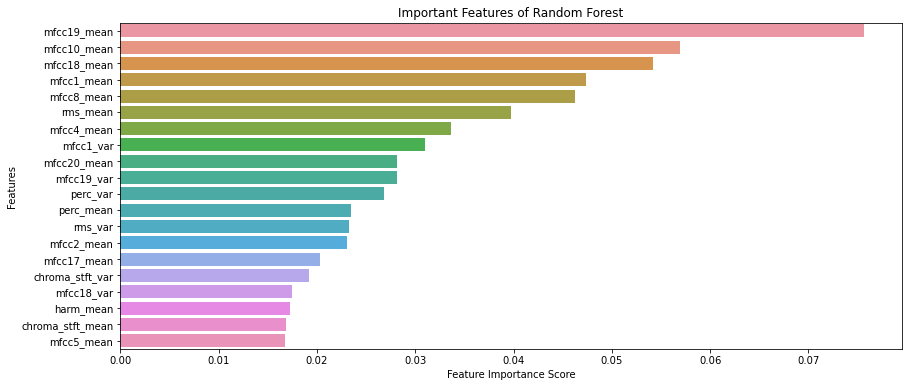

In [43]:
plt.figure(figsize=(14,6))
feature_importance = pd.DataFrame({'cols':X_train.columns, 'Importance': RFmodel_500trs.feature_importances_}).sort_values('Importance',ascending = False)
sns.barplot(x='Importance',y='cols',data = feature_importance[:20])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features of Random Forest")
plt.show()

### Comparing to the original data

Compare to the original data(without acoustic feature engineering), the predict accuracy increase obviously!!

In [44]:
Xtrain = df.iloc[:,:5000]
ytrain = df.iloc[:,5000].map({b'melanogaster': 0,b'suzukii': 1,b'zaprionus':2})
Xtest = df_test.iloc[:,:5000]
ytest = df_test.iloc[:,5000].map({b'melanogaster': 0,b'suzukii': 1,b'zaprionus':2})

In [46]:
RFmodel_Raw_50trs = RandomForestClassifier(n_estimators=500,random_state = 2021)
RFmodel_Raw_50trs.fit(Xtrain,ytrain)

RandomForestClassifier(n_estimators=500, random_state=2021)

In [47]:
ypred = RFmodel_Raw_50trs.predict(Xtest)
acc = sum(ytest == ypred)/len(ytest)
print('Accuracy equals to ', acc)

Accuracy equals to  0.8248450084014137


# Discussion

By comparing the confusion matrix of three model, I can see that as the number of trees become larger, the predict accuracy of suzukii and zaprionus increase obviously. While predict accuracy of melanogaster tends to be stable even *go down*.

I think there could be two explanations for this phenomenon:

1. It may due to the **imbalance of classes**. This algorithm learn more on the majority class. It just like, in a forest, more trees are trend to vote for the other two species(suzukii, zaprionus). Therefore, the number of data points classified as melangogaster will be fewer and other two grows. It also explan the reason why the accuracy of melanogaster goes down as the n_estimator increase. 


2. The reason could also be the distribution of melanogaster have very **high variance**. I means it just hard to be distinguished from the other two types. This conclusion may get supported by the PCA plot in EDA.

Another interesting thing is the "suzukii" species are more misclassified to "melangogaster" species rather than the majority one(zaprionus).

I think the reason might be **these two species have more similar acoustic characteristics of wingbeats.** This conclusion could also be proved by the boxplot made in EDA. The boxplots show there are obvious distribution differences in mfcc19_mean and chroma_stft between zaprionus with other two species.

# Further Work

For the further work, I'd like to balance this dataset first, then run random forest agian with tunning to see how high accuracy the random forest can reach.

And I also plan to use others algorithm like XGBoost to fit this data. I think XGBoost might have a better results because the boosting strategy focus on the errors. 

# Reference

Andradaolteanu. (2020, March 25). Work w/ Audio Data: Visualise, Classify, recommend. Retrieved February 10, 2021, from https://www.kaggle.com/andradaolteanu/work-w-audio-data-visualise-classify-recommend

Zero-crossing rate. (2020, December 14). Retrieved February 10, 2021, from https://en.wikipedia.org/wiki/Zero-crossing_rate#:~:text=The%20zero%2Dcrossing%20rate%20(ZCR,feature%20to%20classify%20percussive%20sounds.